# EnMAP SNR Experiment Runner

This notebook orchestrates the eight-case SNR experiment (cases A-H) for EnMAP scenes via `scripts.snr_experiment`. Each case toggles destriping, PCA residual order, and aggregation (columnwise vs. PCA component 4) so we can compare noise behaviour under different assumptions. The resulting CSV/PNG artefacts under `notebooks/outputs/enmap/<scene_id>/` capture destriping diagnostics, PCA summaries, and SNR curves defined as $SNR(\lambda) = L(\lambda)/\sigma(\lambda)$.


## Prerequisites

- Install the scientific stack listed in `environment.min.yml` (`numpy`, `scipy`, `scikit-learn`, `matplotlib`, `scikit-image`, GDAL).
- Provide EnMAP L1B inputs: VNIR & SWIR GeoTIFFs plus `METADATA.XML`. You may pass either a directory containing these files or explicit file paths.
- (Optional) Define ROIs, spectral windows, destriping, and PCA options per scene using the configuration dictionaries below so notebook runs match CLI behaviour.


In [1]:
import os
import sys
import subprocess
from pathlib import Path
from datetime import datetime
from typing import Iterable, Optional

from IPython.display import Markdown, display

NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT
while not (REPO_ROOT / 'scripts').exists() and REPO_ROOT.parent != REPO_ROOT:
    REPO_ROOT = REPO_ROOT.parent
if not (REPO_ROOT / 'scripts').exists():
    raise RuntimeError('Could not locate repository root containing scripts directory.')
os.environ['PYTHONPATH'] = str(REPO_ROOT)
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
PYTHON = sys.executable
DEFAULT_OUTDIR = NOTEBOOK_ROOT / 'outputs'
DEFAULT_OUTDIR.mkdir(parents=True, exist_ok=True)



In [2]:
display(Markdown(
    f"""\n**Notebook root**: `{NOTEBOOK_ROOT}`  \\n**Python**: `{PYTHON}`  \\n**PYTHONPATH**: `{os.environ['PYTHONPATH']}`\n"""
))



**Notebook root**: `/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks`  \n**Python**: `/home/esivla/miniconda3/envs/hygasMF/bin/python`  \n**PYTHONPATH**: `/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas`


In [3]:
def run_snr_experiment(
    sensor: str,
    inputs: Iterable[str],
    roi: Optional[str] = None,
    bands: Optional[str] = None,
    cases: Optional[str] = None,
    disable_notch: bool = False,
    extra_args: Optional[Iterable[str]] = None,
    outdir: Optional[str] = None,
):
    """Invoke the consolidated CLI for a single EnMAP scene."""

    target_outdir = Path(outdir) if outdir else DEFAULT_OUTDIR
    target_outdir.mkdir(parents=True, exist_ok=True)

    cmd = [
        PYTHON,
        "-m",
        "scripts.snr_experiment",
        "--sensor",
        sensor,
        "--input",
    ]
    cmd.extend(str(path) for path in inputs)
    if roi:
        cmd.extend(["--roi", roi])
    if bands:
        cmd.extend(["--bands", bands])
    if cases:
        cmd.extend(["--cases", cases])
    if disable_notch:
        cmd.append("--disable-notch")
    cmd.extend(["--outdir", str(target_outdir)])
    if extra_args:
        cmd.extend(str(arg) for arg in extra_args)

    display(Markdown(f"**Running**: `{' '.join(cmd)}`"))
    start = datetime.now()
    result = subprocess.run(cmd, capture_output=True, text=True, env=os.environ.copy())
    duration = datetime.now() - start
    status = "success" if result.returncode == 0 else f"failed (code {result.returncode})"

    display(Markdown(f"- Status: **{status}** in {duration.total_seconds():.1f}s"))
    if result.stdout:
        display(Markdown(f"<details><summary>stdout</summary><pre>{result.stdout}</pre></details>"))
    if result.stderr:
        display(Markdown(f"<details><summary>stderr</summary><pre>{result.stderr}</pre></details>"))

    return result


### CLI invocation details
`run_snr_experiment` shells out to `python -m scripts.snr_experiment` with the requested sensor, inputs, ROI/band window, and case list. The CLI itself loads the radiance data, applies optional destriping, evaluates PCA residuals, and writes SNR statistics per wavelength. Because the command returns a `subprocess.CompletedProcess`, you can inspect `.returncode`, `.stdout`, or `.stderr` to debug failures or tweak arguments.


## Outputs and Interpretation

Each run writes `outputs/enmap/<scene_id>/` containing:
- `striping_diagnostics.png`: before/after destriping radiance, column means, and MAD to quantify equalisation success.
- `snr_cases_<case>.csv` + `_overview.png`: per-case SNR statistics (median, percentiles) across wavelength and comparisons between cases (e.g., destriped vs. plain).
- `pca_summary_plain.png` / `_destriped.png`: PCA diagnostics for raw and destriped cubes (see details below).
- `snr_cases_plots/<case>_*.png`, logs, and ancillary CSVs capturing the CLI arguments and intermediate metrics.

Use these artefacts together: destriping plots reveal if striping drives low SNR, the PCA figures describe how much variance each component captures and where artefacts sit spatially, while the SNR curves show wavelength ranges where noise dominates.


### PCA diagnostic imagery
Each PCA summary figure shares a consistent layout:
- **Explained variance panel** (top-left) shows per-component variance bars and the cumulative curve, so you can see whether most structure collapses into the first few PCs. If destriping works, the cumulative curve for the destriped run should rise faster with fewer components capturing the bulk variance.
- **Component loadings** (top-right) plot PC spectra versus wavelength, revealing whether the PCs capture broadband brightness (flat loadings) or striping/absorption-driven features (oscillatory loadings).
- **Residual maps** (middle-left) display SWIR and VNIR bands after reconstructing with the retained PCs; stripe ghosts or unmodelled artefacts appear as alternating columns.
- **Reference-pixel spectra** (middle-right) compare the original spectrum, PCA reconstruction, and residual at a representative pixel to highlight reconstruction fidelity around methane windows.
- **Score maps** (bottom row) visualise spatial patterns of the first PCs; coherent stripes concentrate in PC1/PC2 for the raw cube, whereas destriping should produce muted, texture-driven scores.

Comparing `pca_summary_plain` and `pca_summary_destriped` therefore clarifies whether equalisation pushed stripe energy into higher-order components (desired) and whether residuals/noise patterns differ between VNIR and SWIR windows.


## Configure EnMAP Scenes

Each dictionary feeds directly into `run_snr_experiment`. Key fields: 
- `inputs`: directory or explicit VNIR/SWIR/XML paths.
- `roi`: optional `x0:x1,y0:y1` window to limit processing (reduces runtime, isolates homogeneous areas).
- `bands`: `min:max` wavelength limits in nm to mirror pipeline spectral selection.
- `cases`: subset of the canonical cases (A-H) if you do not wish to run all eight.
- `extra_args`: destriping knobs such as `--equalize-scale-strength`, `--equalize-scale-cap`, `--equalize-poly-order`, or `--disable-notch`.
Adjust these so notebook experiments stay reproducible and comparable against CLI runs.


In [4]:
SCENE_CONFIGS = [
    # Example configuration using the test dataset shipped with the repo:
    {
        "sensor": "enmap",
        "inputs": [
            "/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Agadez_Niger_20220712/L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z/"
            # or explicitly:
            # "/path/EnMAP/.../SPECTRAL_IMAGE_VNIR.TIF",
            # "/path/EnMAP/.../SPECTRAL_IMAGE_SWIR.TIF",
            # "/path/EnMAP/.../METADATA.XML",
        ],
        # "roi": "x0:x1,y0:y1",  # optional subwindow (columns,rows)
        "bands": "1000:2500",  # optional wavelength range in nm
        "cases": "A,B,C,D,E,F,G,H",
        # add destriping tuning here, e.g.
        "extra_args": [
            "--mask-frac", "1",
            "--diff-axis", "columns",
            "--k-pca", "4",
            #"--disable-equalize",
            "--equalize-scale-strength", "0.5",
            "--equalize-scale-cap", "1.5",
            "--equalize-poly-order", "1",
        ],
        "disable_notch": True,
    },
]
SCENE_CONFIGS

[{'sensor': 'enmap',
  'inputs': ['/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Agadez_Niger_20220712/L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z/'],
  'bands': '1000:2500',
  'cases': 'A,B,C,D,E,F,G,H',
  'extra_args': ['--mask-frac',
   '1',
   '--diff-axis',
   'columns',
   '--k-pca',
   '4',
   '--equalize-scale-strength',
   '0.5',
   '--equalize-scale-cap',
   '1.5',
   '--equalize-poly-order',
   '1'],
  'disable_notch': True}]

## Run Experiments

The loop below iterates over `SCENE_CONFIGS`, calls `run_snr_experiment` for each, and short-circuits if any CLI invocation returns a non-zero exit code. This mirrors production automation: every run writes a timestamped folder under `DEFAULT_OUTDIR/<sensor>/scene_id/`, so rerunning the notebook accumulates comparable experiment trails.


In [5]:
results = []
for cfg in SCENE_CONFIGS:
    result = run_snr_experiment(**cfg)
    results.append((cfg, result))
    if result.returncode != 0:
        break

results

**Running**: `/home/esivla/miniconda3/envs/hygasMF/bin/python -m scripts.snr_experiment --sensor enmap --input /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Agadez_Niger_20220712/L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z/ --bands 1000:2500 --cases A,B,C,D,E,F,G,H --disable-notch --outdir /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs --mask-frac 1 --diff-axis columns --k-pca 4 --equalize-scale-strength 0.5 --equalize-scale-cap 1.5 --equalize-poly-order 1`

- Status: **success** in 177.9s

<details><summary>stdout</summary><pre>SNR experiment completed. Outputs stored in /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/enmap/L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z
</pre></details>

<details><summary>stderr</summary><pre>/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/scripts/diagnostics/plots.py:21: RuntimeWarning: Mean of empty slice
  col_mean = np.nanmean(values, axis=0)
/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
</pre></details>

[({'sensor': 'enmap',
   'inputs': ['/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Agadez_Niger_20220712/L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z/'],
   'bands': '1000:2500',
   'cases': 'A,B,C,D,E,F,G,H',
   'extra_args': ['--mask-frac',
    '1',
    '--diff-axis',
    'columns',
    '--k-pca',
    '4',
    '--equalize-scale-strength',
    '0.5',
    '--equalize-scale-cap',
    '1.5',
    '--equalize-poly-order',
    '1'],
   'disable_notch': True},
  CompletedProcess(args=['/home/esivla/miniconda3/envs/hygasMF/bin/python', '-m', 'scripts.snr_experiment', '--sensor', 'enmap', '--input', '/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Agadez_Niger_20220712/L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z/', '--bands', '1000:2500', '--cases', 'A,B,C,D,E,F,G,H', '--disable-notch', '--outdir', '/mnt/d/Lavoro/Assegno_Ricerca_Sapienza

## Inspect Outputs

After the CLI finishes, this helper lists CSVs/PNGs in `DEFAULT_OUTDIR/enmap` and previews representative diagnostic images. Use it to verify that all eight cases were generated (one CSV per case) and to manually sanity-check striping/SNR trends before exporting plots or aggregating metrics elsewhere.


Found 8 CSV files, 1 SNR overview plots, 1 striping diagnostics, and 2 PCA summaries.

#### SNR overview

**L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z / snr_cases_overview.png**

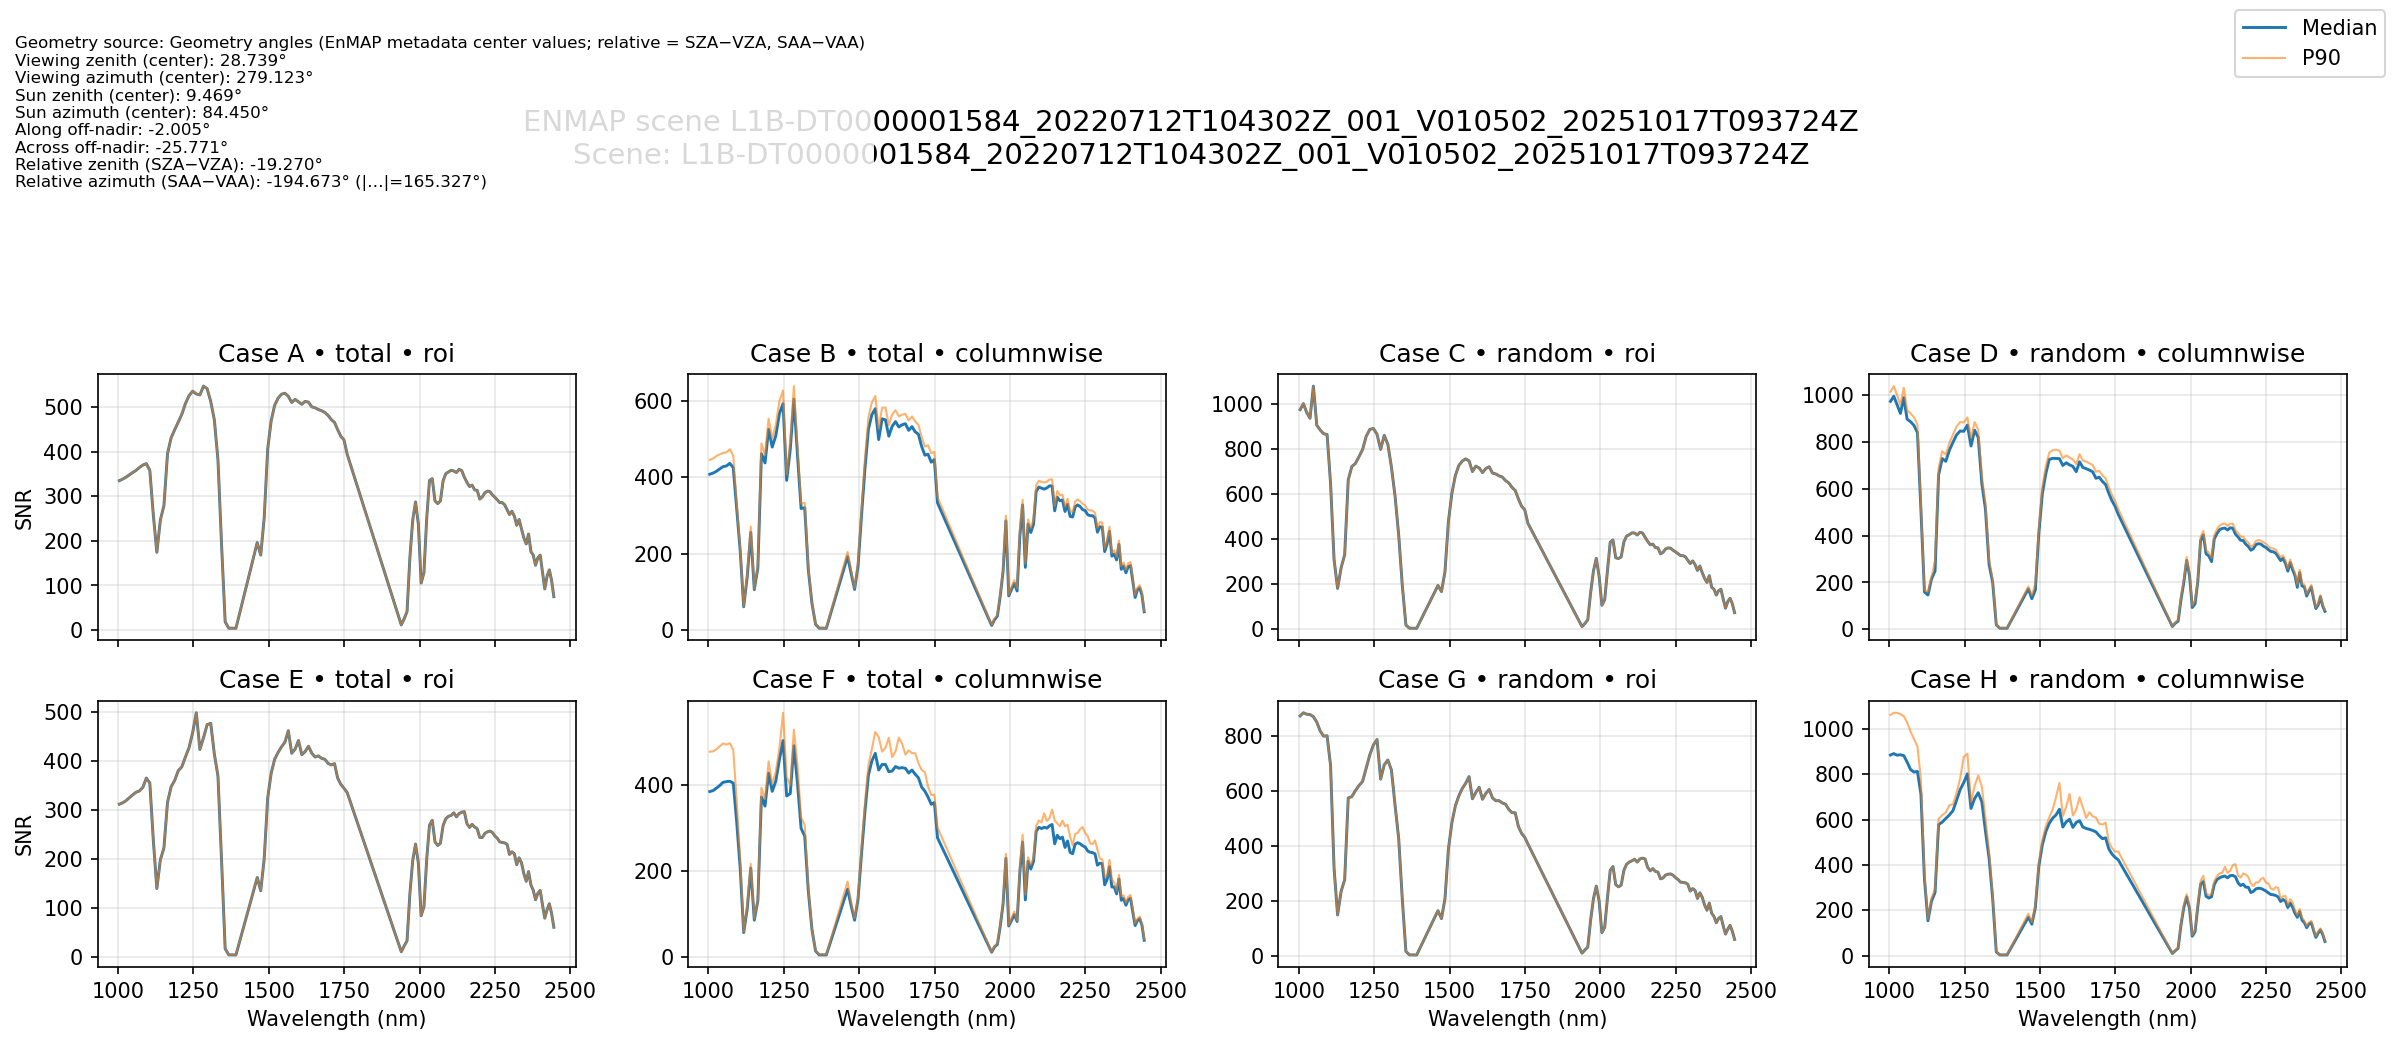

#### Striping diagnostics

**L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z / striping_diagnostics.png**

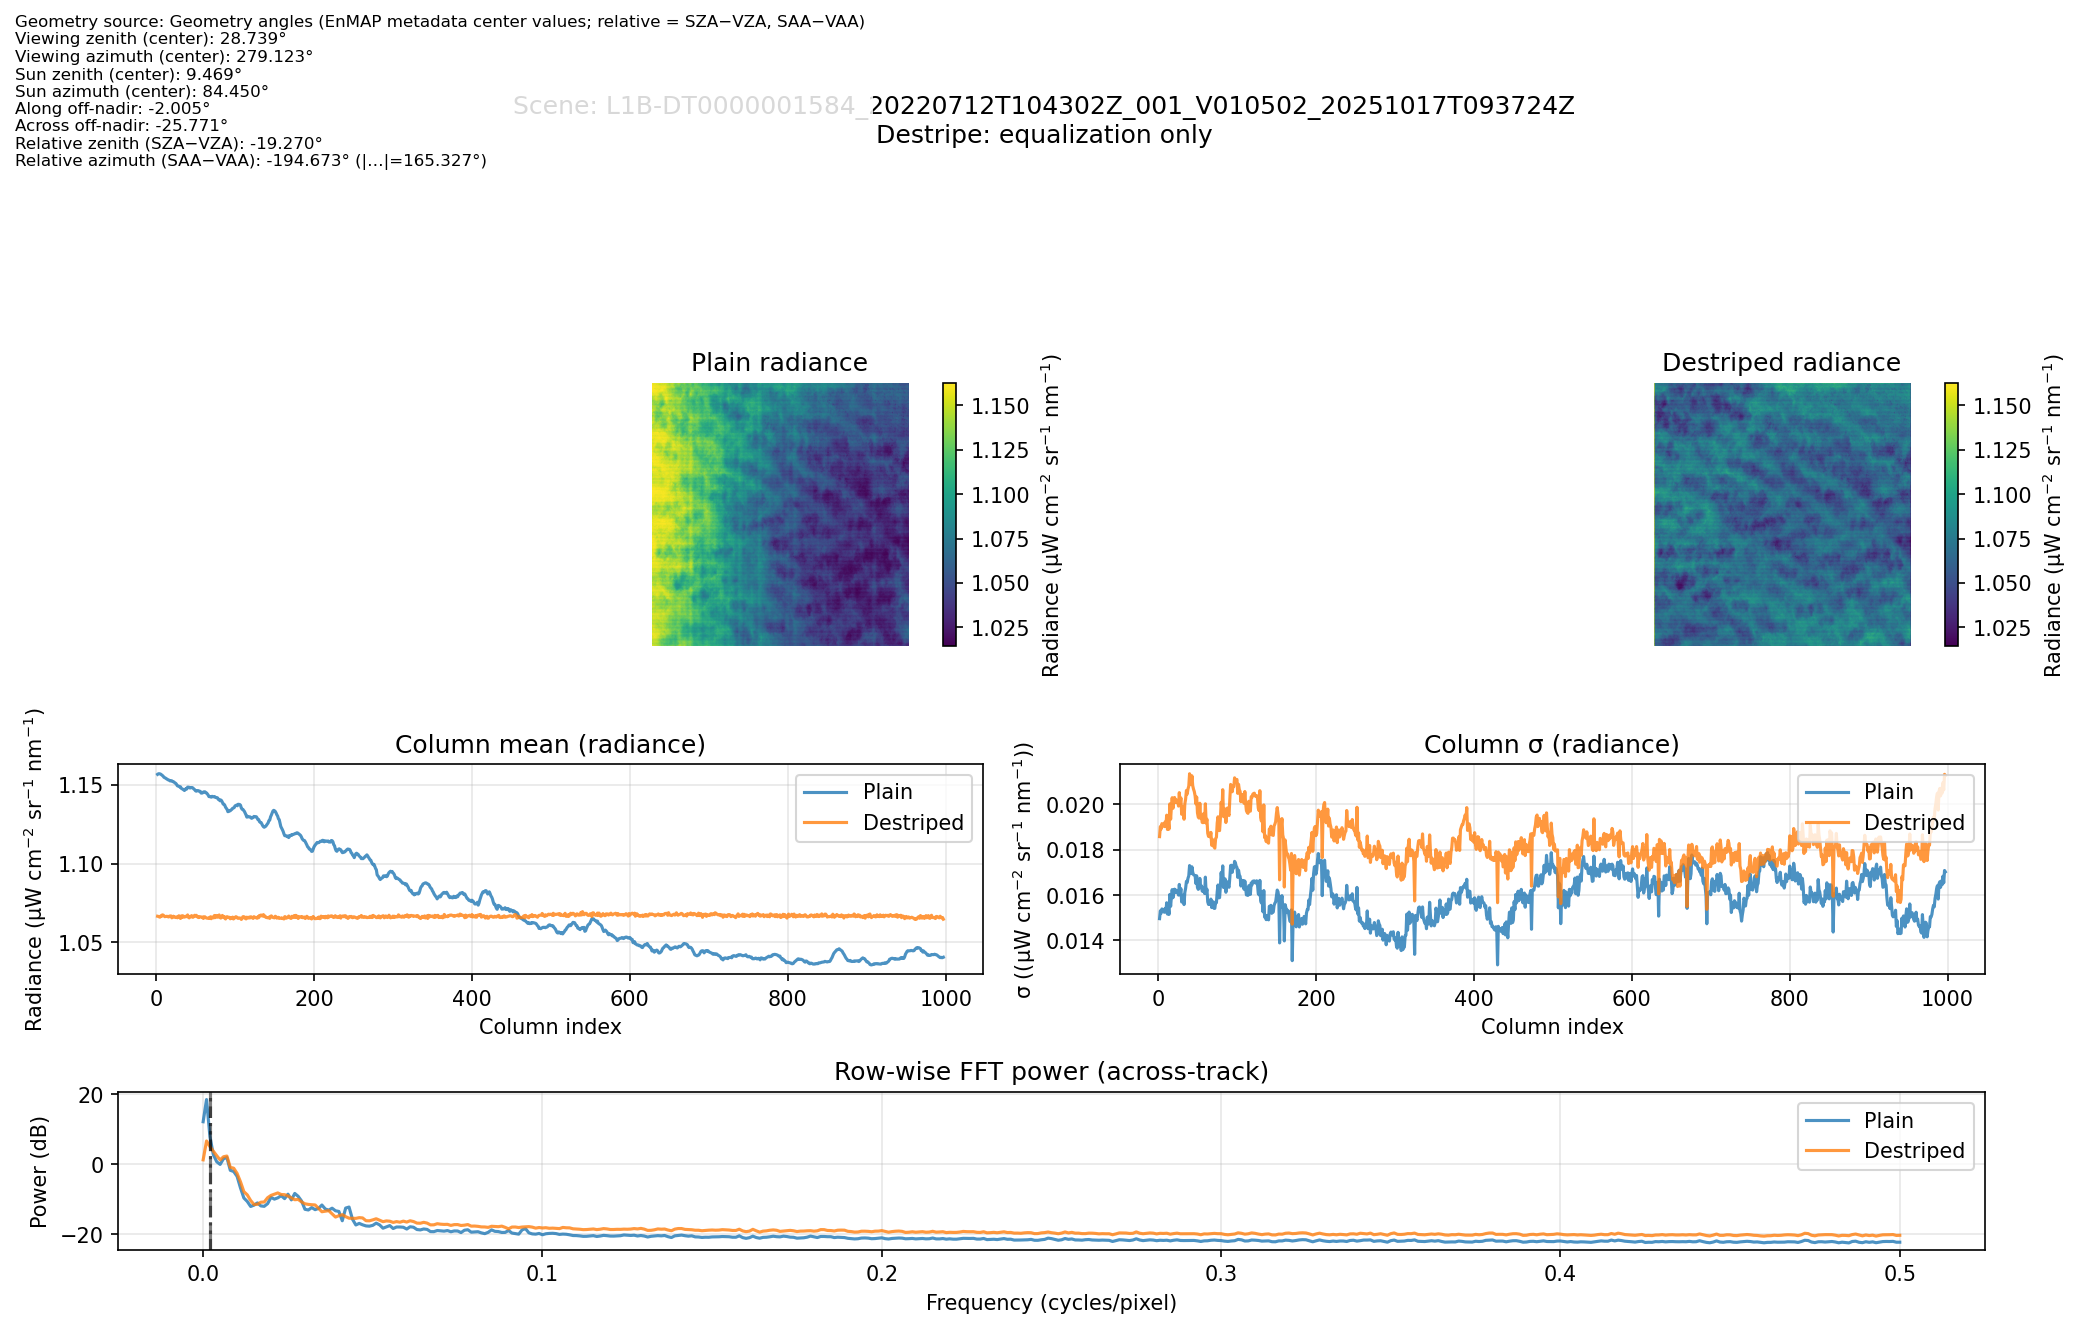

#### PCA summaries

**L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z / pca_summary_destriped.png**

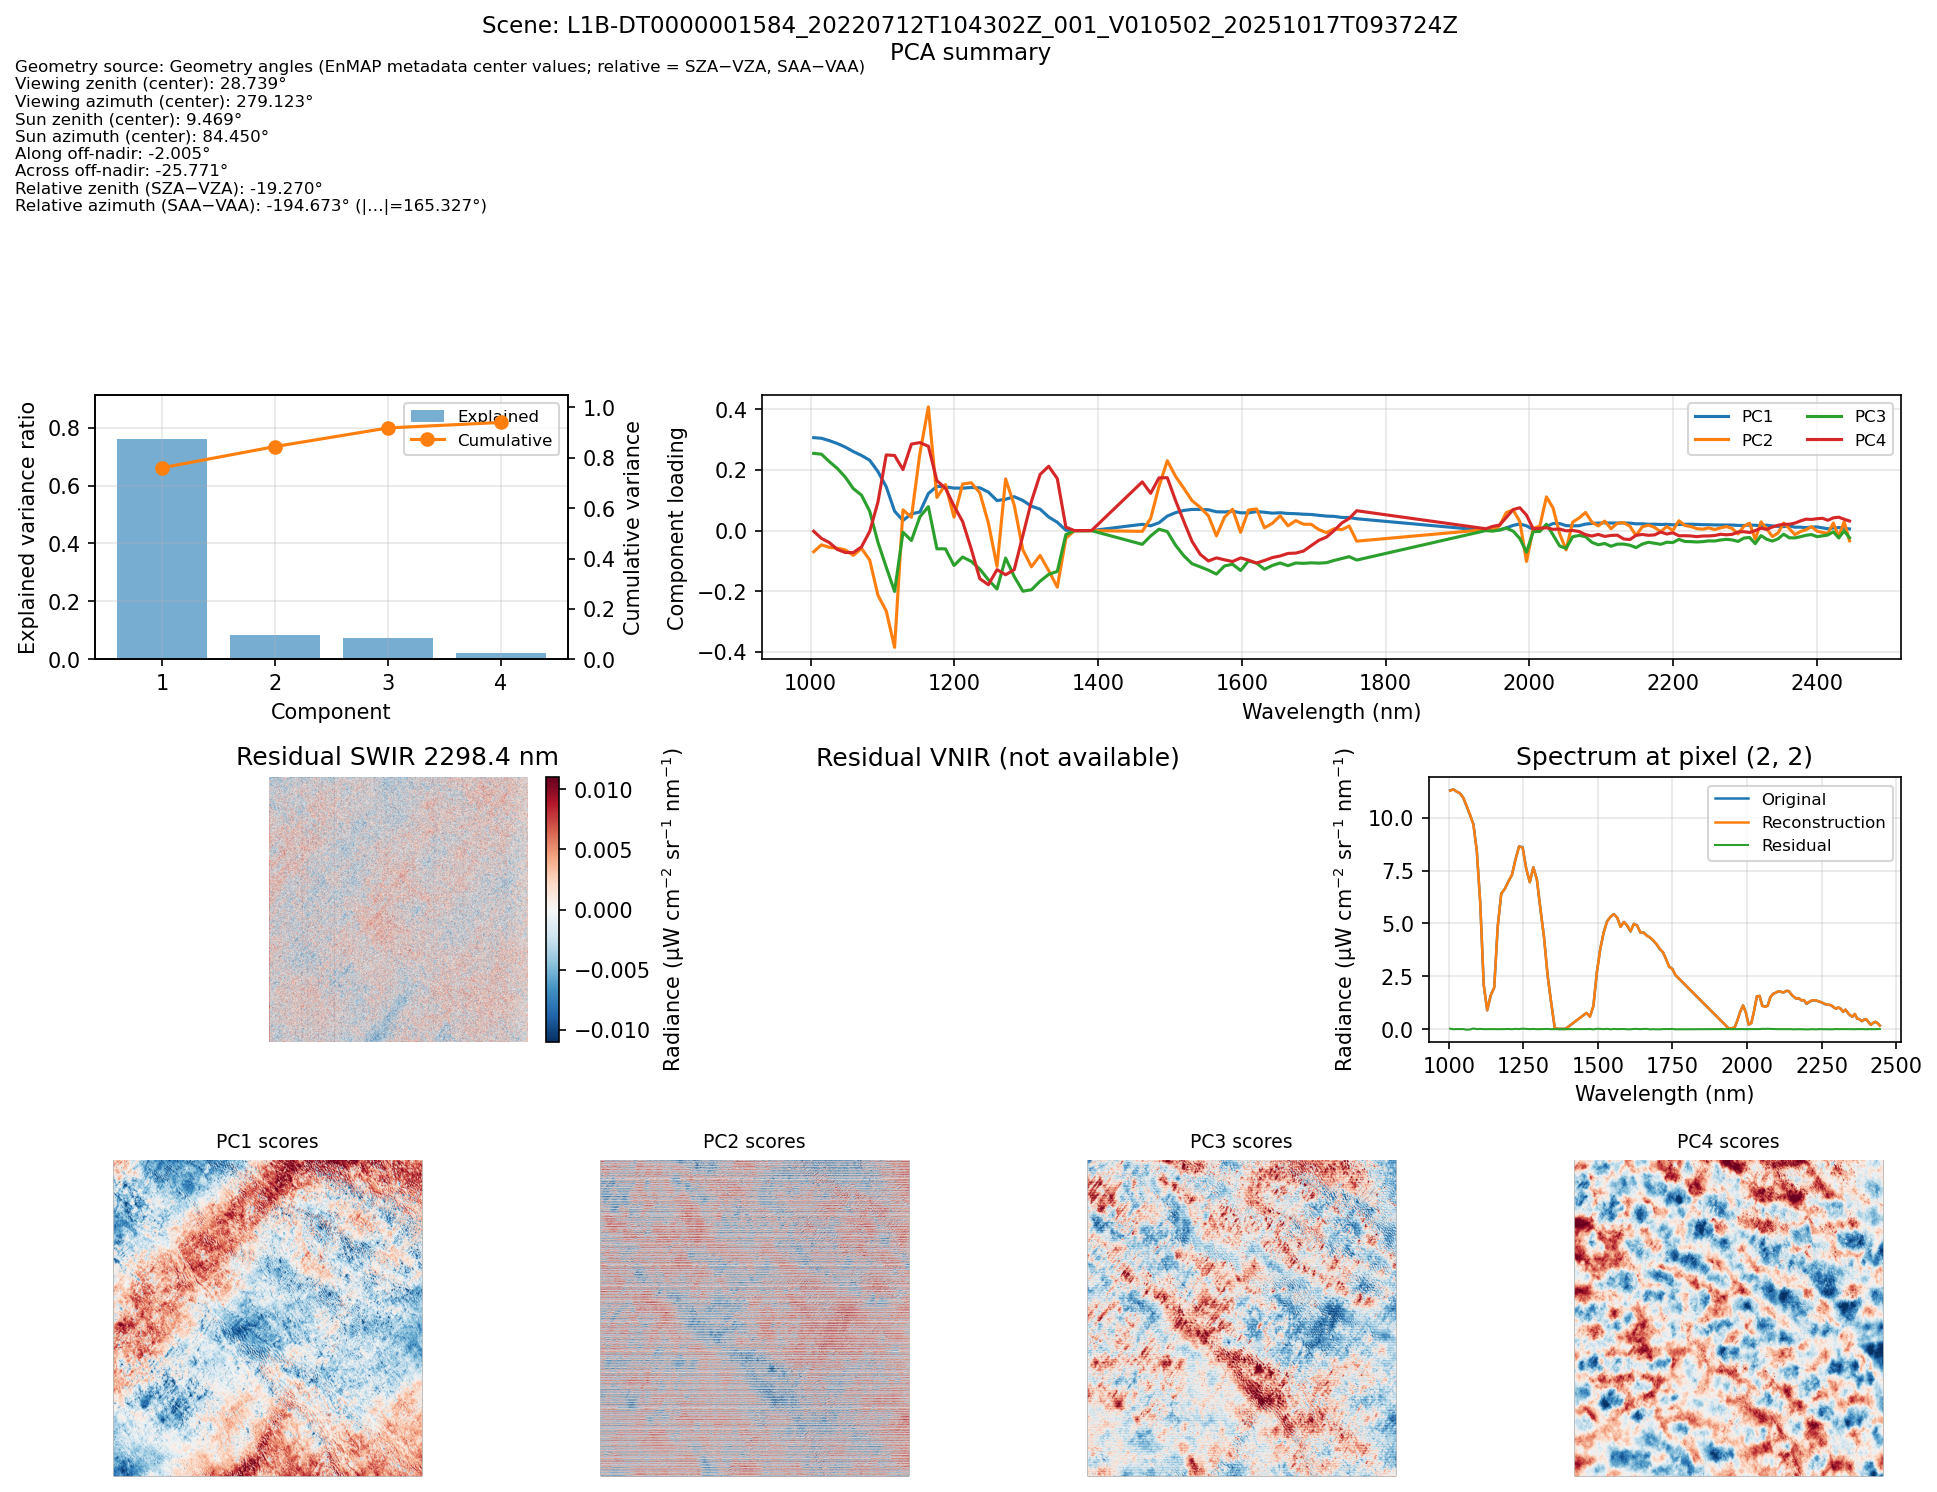

**L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z / pca_summary_plain.png**

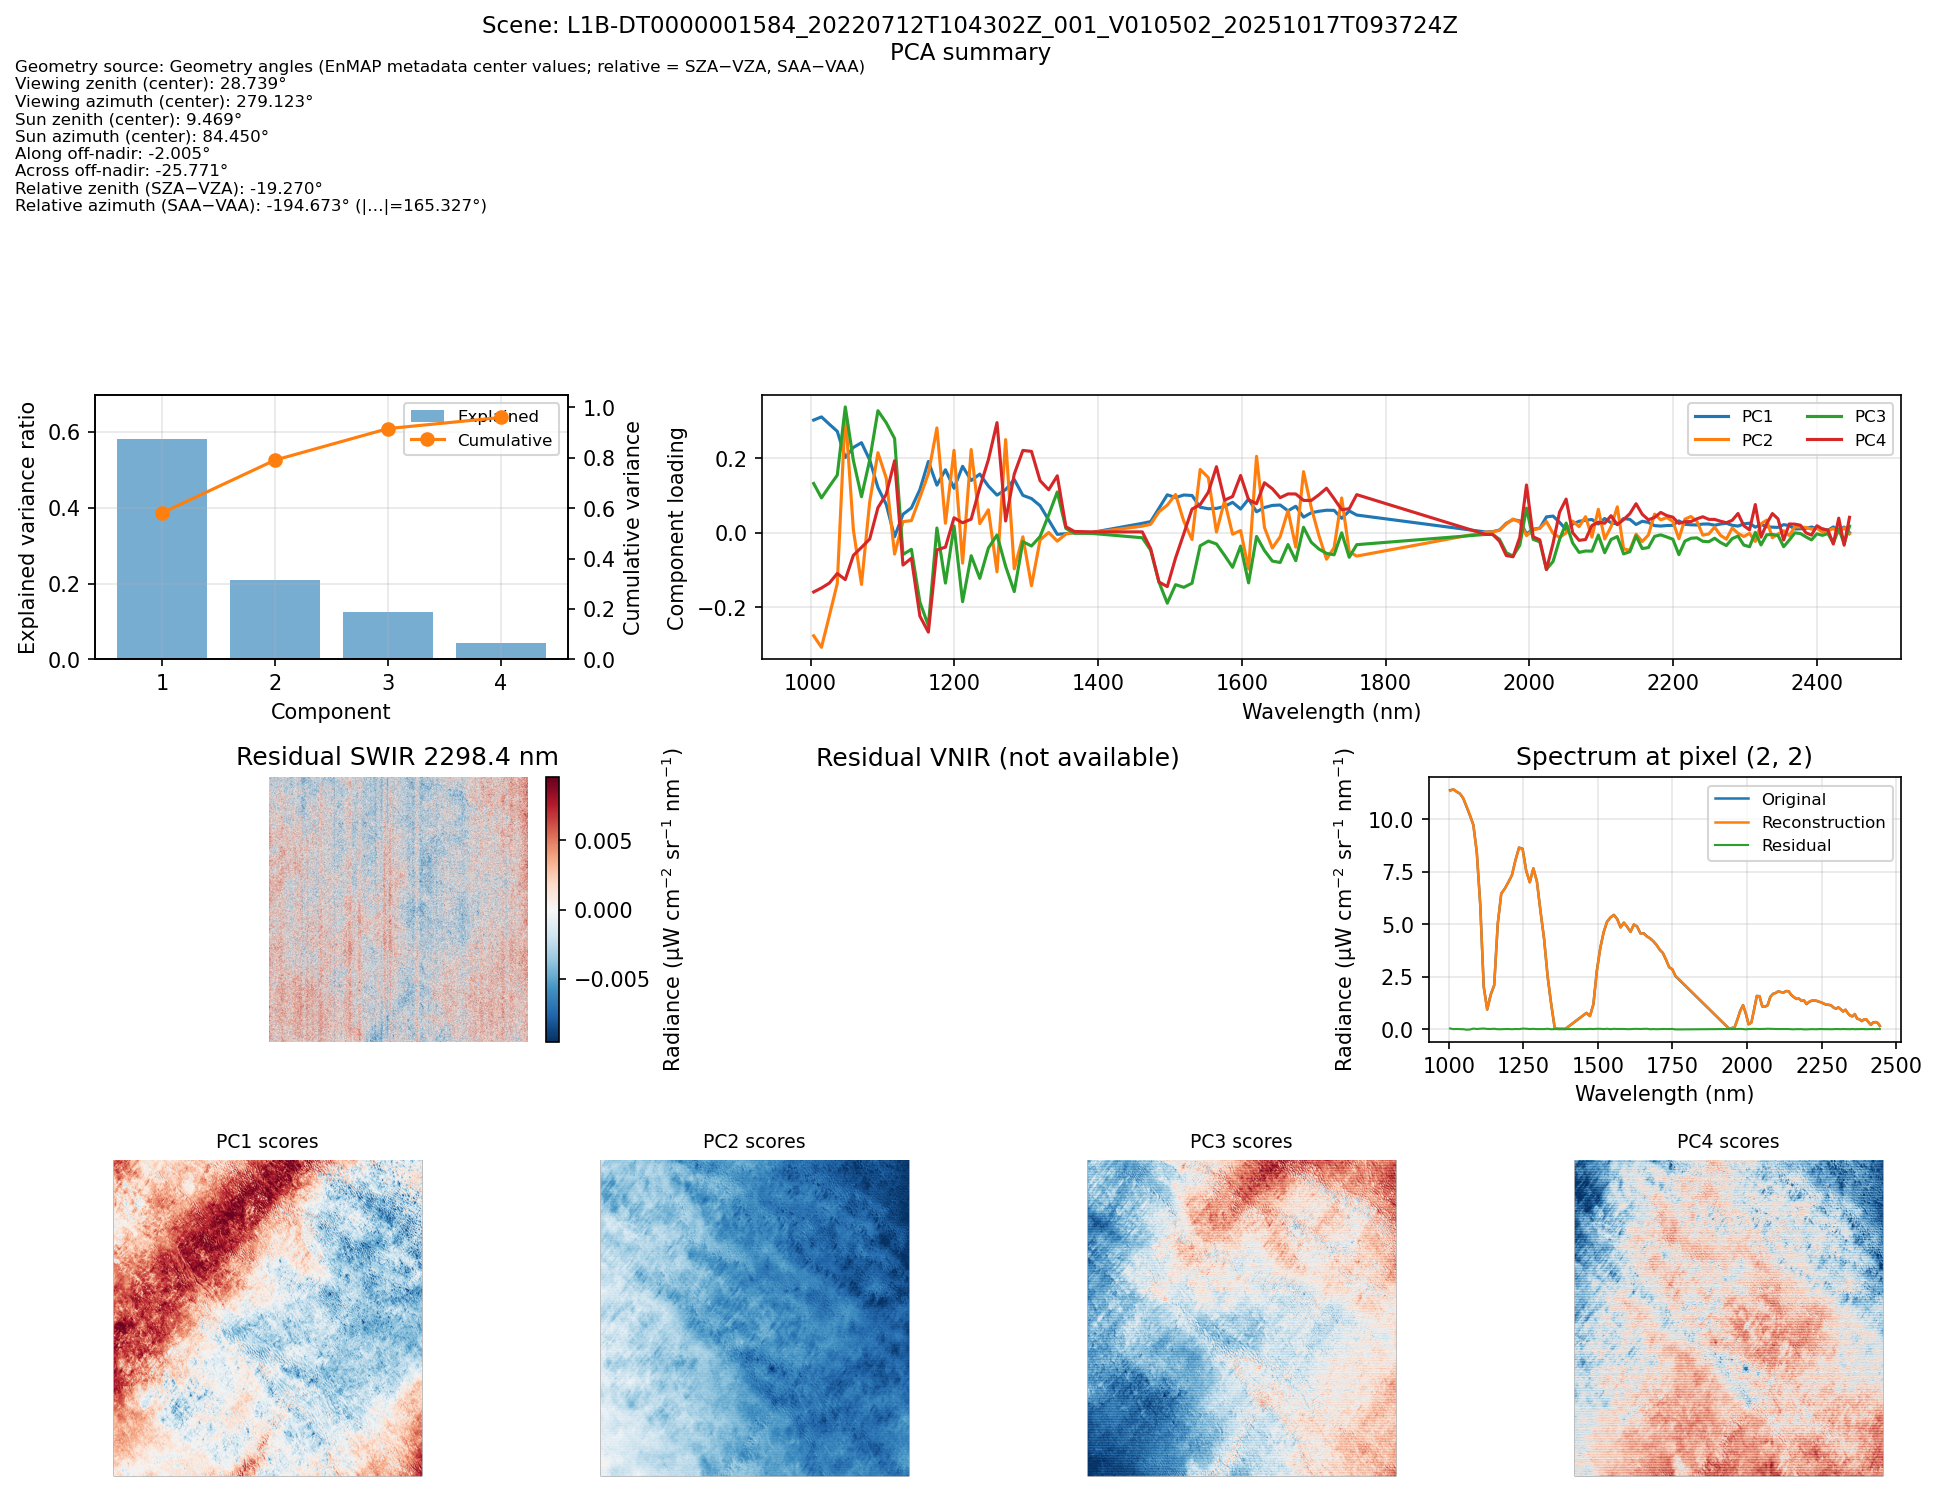

In [6]:
from glob import glob
from IPython.display import Image

output_root = (DEFAULT_OUTDIR / "enmap")
output_root.mkdir(parents=True, exist_ok=True)

if output_root.exists():
    csv_paths = sorted(output_root.glob("**/snr_cases_*.csv"))
    overview_pngs = sorted(output_root.glob("**/snr_cases_overview.png"))
    striping_pngs = sorted(output_root.glob("**/striping_diagnostics.png"))
    pca_pngs = sorted(output_root.glob("**/pca_summary_*.png"))

    display(Markdown(
        f"Found {len(csv_paths)} CSV files, {len(overview_pngs)} SNR overview plots, "
        f"{len(striping_pngs)} striping diagnostics, and {len(pca_pngs)} PCA summaries."
    ))

    if overview_pngs:
        display(Markdown("#### SNR overview"))
        for png in overview_pngs:
            display(Markdown(f"**{png.parent.relative_to(output_root)} / {png.name}**"))
            display(Image(filename=str(png)))

    if striping_pngs:
        display(Markdown("#### Striping diagnostics"))
        for png in striping_pngs:
            display(Markdown(f"**{png.parent.relative_to(output_root)} / {png.name}**"))
            display(Image(filename=str(png)))

    if pca_pngs:
        display(Markdown("#### PCA summaries"))
        for png in pca_pngs:
            display(Markdown(f"**{png.parent.relative_to(output_root)} / {png.name}**"))
            display(Image(filename=str(png)))
else:
    display(Markdown("`outputs/enmap` directory not found yet. Run at least one experiment."))
